<img src=https://news.airbnb.com/wp-content/uploads/sites/4/2020/04/Airbnb_Lockup_Over_Gradient.png width="1000"/>

# 1. Summary
***

## Exploration
1. **Mature listings** with the **highest number of reviews** in the last 12 months are mostly located near **tourist areas**, are hosted by **commericial entities**, have **'Private room'** room type and have **low minimum nights** while **mature listings** with the **lowest number of reviews** in the last 12 months are mostly located near **residential areas**, are hosted by **individuals**, have **'Entire home/apt'** room type and have **high minimum nights**.
2. **Hosts who have mature listings** with the **highest number of reviews** in the last 12 months are mostly **commericial entities** while **hosts who have mature listings** with the **lowest number of reviews** in the last 12 months are mostly **individuals**.
3. On median, **listings with higher prices or minimum nights** have **lower number of reviews** in the last 12 months.
4. On median, **'Entire home/apt'** room types have the **highest number of reviews** in the last 12 months while **'Shared room'** room types have the **lowest number of reviews** in the last 12 months.
5. On median, **listings without indicated licenses** have **higher number of reviews** in the last 12 months.

Notes:
* Mature listings are listings with number of reviews in total >= 10.

## Modeling

Logistic Regression Final Model:

    number_of_reviews_ltm_greater48 = - 1.587977*(room_type_Shared room) - 2.403703*(price) - 4.740241*(minimum_nights)
                
With 100% precision and 94% recall, this model can classify if a listing has its number of reviews in the last 12 months < 48 (i.e. < 1 review per week); since a listing's number of reviews in total highly correlates with its number of reviews in the last 12 months, this model should also hold for its number of reviews in the next 12 months.
* **Positive** features (increases the likelihood of a listing's total number of reviews in the last 12 months >= 48): None.
* **Negative** features (decreases the likelihood of a listing's total number of reviews in the last 12 months < 48): Room type = 'Shared room', Price (USD) > 0 and Minimum nights > 0.
* **Baseline** features (neutral): Room type = 'Entire home/apt'.

## Recommendations
1. If hosts who are individuals with 'Entire home/apt' room type listings or who have 'Shared room' room type listings need help getting more reviews (which should ultimately translate to more bookings/sales), advise them to lower their prices and/or number of minimum nights or change their listings' room type to 'Private room'.
2. If hosts who have listings with indicated licenses need help getting more reviews (which should ultimately translate to more bookings/sales), advise them to remove their licensing information unless it's a legal requirement.

# 2. Introduction
***

## Purpose 
Analyze and model the dataset to find any insights

## Data 
**Airbnb** listings data for all available USA entries from **Inside Airbnb** as of November 12, 2022; includes host name, room type, price, number of reviews, latitude, longitude, state, etc.

# 3. Collection
***

## Libraries

In [1]:
# General purpose
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# General modeling
from scipy import stats
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Specific modeling: Regression Algorithms
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

# Specific Modeling: Classification Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

## Data

In [2]:
# Read then view
airbnb_usa = pd.read_csv('../input/airbnb-listings-usa/airbnb_listings_usa.csv')

airbnb_usa.head(5)

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Unnamed: 0,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,...,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license,state,city
0,0,183319,Panoramic Ocean View Venice Beach,867995,Barbara X,City of Los Angeles,Venice,33.99211,-118.47600,Entire home/apt,...,30,3,2019-02-25,0.02,2,0,0,NaN,CA,Los Angeles
1,1,109,Amazing bright elegant condo park front *UPGRA...,521,Paolo,Other Cities,Culver City,33.98301,-118.38607,Entire home/apt,...,30,2,2016-05-15,0.01,1,139,0,NaN,CA,Los Angeles
2,2,51307,Spanish Bungalow Guest House LA CA. 30 plus ni...,235568,David,City of Los Angeles,Atwater Village,34.12206,-118.26783,Entire home/apt,...,30,138,2020-12-13,0.98,2,224,0,NaN,CA,Los Angeles
3,3,184314,Boho Chic Flat..Steps to Beach!,884031,Ashley,City of Los Angeles,Venice,33.97487,-118.46312,Entire home/apt,...,30,30,2017-12-24,0.22,1,0,0,NaN,CA,Los Angeles
4,4,51498,Guest House With Its Own Entrance/Exit and Hot...,236758,Bay,City of Los Angeles,Mar Vista,34.00389,-118.44126,Entire home/apt,...,3,378,2022-08-21,2.60,1,348,41,HSR19-001336,CA,Los Angeles


In [3]:
# View its summary statistics for numerical fields
airbnb_usa.describe()

,Unnamed: 0,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
count,325858.000000,3.258580e+05,3.258580e+05,325858.000000,325858.000000,325858.000000,325858.000000,325858.000000,263166.00000,325858.000000,325858.000000,325858.000000
mean,162928.500000,1.541106e+17,1.446528e+08,34.676058,-106.354815,284.915304,13.430175,39.457850,1.69220,27.108900,182.361099,11.889817
std,94067.246346,2.736013e+17,1.449951e+08,6.213029,24.176674,835.569711,28.783033,75.724832,2.01294,79.983052,134.095115,20.672830
min,0.000000,1.090000e+02,2.300000e+01,18.920250,-159.714620,0.000000,1.000000,0.000000,0.01000,1.000000,0.000000,0.000000
25%,81464.250000,2.394619e+07,2.311836e+07,32.775202,-118.410259,97.000000,2.000000,1.000000,0.33000,1.000000,55.000000,0.000000
50%,162928.500000,4.511097e+07,9.320864e+07,34.102360,-117.131590,159.000000,3.000000,9.000000,1.01000,2.000000,174.000000,3.000000
75%,244392.750000,5.420558e+07,2.388338e+08,39.948015,-82.549423,275.000000,30.000000,42.000000,2.49000,12.000000,322.000000,16.000000
max,325857.000000,7.251653e+17,4.810023e+08,47.748000,-70.913250,100000.000000,1250.000000,2600.000000,190.48000,660.000000,365.000000,1284.000000


In [4]:
# View its summary statistics for string fields
airbnb_usa.drop(airbnb_usa.describe(), axis='columns').describe()

,name,host_name,neighbourhood_group,neighbourhood,room_type,last_review,license,state,city
count,325839,324714,155047,325146,325858,263166,86635,325858,325858
unique,264019,33120,34,1575,4,2965,48064,19,31
top,Boutique Hostel,Blueground,City of Los Angeles,Unincorporated Areas,Entire home/apt,2022-09-05,Exempt,CA,Los Angeles
freq,152,4876,39002,13400,243098,13190,6603,127329,91630


Notes:
* **Unnamed: 0** is a generic row id (no inherent value)
* **id** and **host_id** aren't sequential (could have some inherent value)
* **price** has a minimum value of 0 (could be erroneous or an inactive listing) and a very high maximum value of 100,000 (could be erroneous or not for a single night's stay); all its values appear to be in USD
* **minimum_nights** , **number_of_reviews**, **reviews_per_month**, **calculated_host_listings_count** and **number_of_reviews_ltm** have very high maximum values (potential outliers)
* **name** can have repeated values (potential duplication)
* **host_name** can be commericial entities (e.g. 'Blueground')
* **neighbourhood_group** is about 50% **null** and has about 20% of its value as 'City of Los Angeles' (could be useless)
* **room_type** is about 75% 'Entire home/apt' (could skew a model if not accounted for)
* **last_review** is in YYYY-MM-DD format
* **license** is about 75% **null**
* **state** has about 50% of its value as 'CA' and **city** has about 25% of its value as 'Los Angeles' (could skew a model if not accounted for)

Since **Unnamed: 0** is a generic row id, let's drop it.

In [5]:
airbnb_usa.drop('Unnamed: 0', axis='columns', inplace=True)

# 4. Preparation
***

## Duplication

In [6]:
print('Duplication (%):', 100*(len(airbnb_usa) - len(airbnb_usa.drop_duplicates()))/len(airbnb_usa),
      '\nDuplication (%) without id:', 
      100*(len(airbnb_usa.drop('id', axis='columns')) - 
           len(airbnb_usa.drop('id', axis='columns').drop_duplicates())) / 
              len(airbnb_usa.drop('id', axis='columns')))

Duplication (%): 14.059805191218262 
Duplication (%) without id: 14.076990590993622


Let's drop all duplication with and without **id**.

In [7]:
airbnb_usa.drop_duplicates(inplace=True)
airbnb_usa.drop_duplicates(subset='name', inplace=True)

## Data types

In [8]:
airbnb_usa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 264020 entries, 0 to 325857
Data columns (total 20 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   id                              264020 non-null  int64  
 1   name                            264019 non-null  object 
 2   host_id                         264020 non-null  int64  
 3   host_name                       263481 non-null  object 
 4   neighbourhood_group             111270 non-null  object 
 5   neighbourhood                   263322 non-null  object 
 6   latitude                        264020 non-null  float64
 7   longitude                       264020 non-null  float64
 8   room_type                       264020 non-null  object 
 9   price                           264020 non-null  int64  
 10  minimum_nights                  264020 non-null  int64  
 11  number_of_reviews               264020 non-null  int64  
 12  last_review     

Let's convert:
* string: **name**, **host_name**, **license**
* category: **neighbourhood_group**, **neighbourhood**, **room_type**, **state**, **city**
* datetime: **last_review**

In [9]:
airbnb_usa = airbnb_usa.astype({'name': 'string', 'host_name': 'string', 'license': 'string', 
                                'neighbourhood_group': 'category', 'neighbourhood': 'category', 
                                'room_type': 'category', 'state': 'category', 'city': 'category'})

airbnb_usa['last_review'] = pd.to_datetime(airbnb_usa['last_review'])

## Numerical fields ranges and formats

In [10]:
airbnb_usa.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
count,2.640200e+05,2.640200e+05,264020.000000,264020.000000,264020.000000,264020.000000,264020.000000,217819.000000,264020.000000,264020.000000,264020.000000
mean,1.492197e+17,1.418405e+08,34.669666,-104.767481,282.903379,12.501814,41.047443,1.718892,23.560302,179.672120,12.480816
std,2.702577e+17,1.440900e+08,6.707990,25.491072,836.681107,28.361691,76.628480,2.011747,69.992886,132.877778,20.717269
min,1.090000e+02,2.300000e+01,18.920250,-159.714620,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000,0.000000
25%,2.348756e+07,2.253885e+07,30.475710,-118.426347,97.000000,2.000000,1.000000,0.350000,1.000000,53.000000,0.000000
50%,4.433749e+07,8.778981e+07,34.206625,-104.981730,159.000000,3.000000,10.000000,1.060000,2.000000,171.000000,3.000000
75%,5.401595e+07,2.335019e+08,40.677782,-80.130278,275.000000,30.000000,45.000000,2.520000,10.000000,318.000000,17.000000
max,7.251653e+17,4.810023e+08,47.748000,-70.913250,100000.000000,1250.000000,1724.000000,190.480000,660.000000,365.000000,949.000000


Since **id** and **host_id** are just identifiers and **latitude** and **longitude** are just coordinates, let's skip them.

Let's check the minimum and maximum observations for **price**.

In [11]:
airbnb_usa.nsmallest(5, 'price')

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license,state,city
16959,40561078,Gold-Diggers Hotel,209561894,Gold Diggers,City of Los Angeles,Hollywood,34.090542,-118.312508,Hotel room,0,1,92,2022-09-08,2.16,2,0,65,<NA>,CA,Los Angeles
16960,40561079,The LINE Hotel,272064927,The LINE Hotel,City of Los Angeles,Koreatown,34.062040,-118.300910,Hotel room,0,1,8,2020-02-16,0.22,1,0,0,<NA>,CA,Los Angeles
17579,41740614,Hotel Erwin,269304681,Hotel Erwin,City of Los Angeles,Venice,33.986950,-118.472480,Hotel room,0,30,145,2022-09-04,4.64,1,0,66,<NA>,CA,Los Angeles
17869,42228983,El Patio Inn,311453463,El Patio Inn,City of Los Angeles,Studio City,34.139410,-118.381100,Hotel room,0,1,0,NaT,NaN,1,0,0,<NA>,CA,Los Angeles
17872,42229033,Nite Inn at Universal City,311439116,Nite Inn @,City of Los Angeles,Studio City,34.137300,-118.364020,Hotel room,0,1,42,2022-07-04,1.66,1,0,17,<NA>,CA,Los Angeles


In [12]:
print('Number of listings with price = 0:', np.sum(airbnb_usa['price']==0))

Number of listings with price = 0: 93


In [13]:
# Check if it's only for room_type = 'Hotel room'
airbnb_usa.loc[airbnb_usa['price']==0, 'room_type'].value_counts()

Hotel room         92
Private room        1
Entire home/apt     0
Shared room         0
Name: room_type, dtype: int64

Some values are invalid: For example, 'Gold-Diggers Hotel' is currently listed as $159/night. Since there are over 90 listings and there is no precise and convenient way to find listings (tried using **id**; even with **name**, you still need to use other variables such as **neighbourhood** to narrow it down), let's leave them as is.

In [14]:
airbnb_usa.nlargest(5, 'price')

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license,state,city
101663,47475849,"WELCOME to ""WORLD MAP SUITE"" in the heart of P...",380705136,Duda,NaN,Mission Bay,32.79190,-117.23807,Private room,100000,1,1,2021-01-09,0.05,1,0,0,<NA>,CA,San Diego
149492,53810192,Enjoy Peace & tranquillity. A home away from home,430653443,Reginald,NaN,Pembroke Pines,26.02708,-80.24724,Entire home/apt,100000,3,14,2022-08-14,1.92,1,365,14,<NA>,FL,Broward
216537,53775685,Entire Cozy Unit(15 mins to Manhattan),245395267,Joes,NaN,Ward E (councilmember James Solomon),40.72330,-74.03946,Entire home/apt,99999,60,6,2022-06-20,0.66,1,70,6,<NA>,NJ,Jersey City
18844,44033589,Villa de la Vina,76993354,Nick,Unincorporated Areas,Unincorporated Santa Monica Mountains,34.11957,-118.79260,Entire home/apt,30000,5,14,2021-09-05,0.72,1,15,0,<NA>,CA,Los Angeles
176749,53150179,"K B M Resorts- BAY-35 Presidential 5bd, 5ba be...",429407284,Kbm,Maui,Lahaina,20.88017,-156.68492,Entire home/apt,26774,1,0,NaT,NaN,166,198,0,"450040490000, TA-041-615-7216-01",HI,Hawaii


Its maximum observations are valid, although the listings themselves may be gag-jokes or just for attention (e.g. 'WELCOME to "WORLD MAP SUITE" in the heart of P.B.!' listing which appears to be just a regular home).

Let's check the maximum observations for **minimum_nights**.

In [15]:
airbnb_usa.nlargest(5, 'minimum_nights')

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license,state,city
236594,4204302,Prime W. Village location 1 bdrm,17550546,Genevieve,Manhattan,Greenwich Village,40.73293,-73.99782,Entire home/apt,180,1250,2,2014-11-09,0.02,1,0,0,<NA>,NY,New York City
110764,15327674,Upscale 2 Bedroom/1.5 Bath with Private Entry,5138158,Barbara,NaN,Inner Richmond,37.77494,-122.47238,Entire home/apt,195,1125,65,2020-05-01,0.90,1,179,0,STR0001667,CA,San Francisco
133179,79867,"DC, Near Metro II",7086,Edward,NaN,"Ivy City, Arboretum, Trinidad, Carver Langston",38.90618,-76.98498,Private room,500,1125,10,2016-09-30,0.08,3,266,0,<NA>,DC,Washington D.C.
133183,4967,"DC, Near Metro",7086,Edward,NaN,"Ivy City, Arboretum, Trinidad, Carver Langston",38.91217,-76.99249,Private room,500,1125,31,2016-09-22,0.21,3,254,0,<NA>,DC,Washington D.C.
134518,18430302,Light filled apartment next to the Big Bear Cafe,15906842,Stuart,NaN,"Edgewood, Bloomingdale, Truxton Circle, Eckington",38.91250,-77.01356,Entire home/apt,98,1125,91,2020-03-01,1.39,1,0,0,<NA>,DC,Washington D.C.


Its maximum observations appear valid.

Let's check the maximum observations for **number_of_reviews**.

In [16]:
airbnb_usa.nlargest(5, 'number_of_reviews')

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license,state,city
125702,8357,The Mushroom Dome Retreat & LAND of Paradise S...,24281,Kitty And Michael,NaN,Unincorporated Areas,37.00939,-121.88547,Entire home/apt,159,2,1724,2022-09-25,10.73,2,100,125,<NA>,CA,Santa Cruz County
17954,42409434,The Burlington Hotel,229716119,Simone,City of Los Angeles,Westlake,34.05981,-118.26963,Entire home/apt,113,1,1702,2022-09-06,56.17,5,124,833,<NA>,CA,Los Angeles
222414,35158303,"SAHARA Las Vegas, Marra 1 King",263748930,SAHARA Las Vegas,NaN,Unincorporated Areas,36.14215,-115.15706,Private room,238,1,1542,2022-09-05,83.80,11,298,860,<NA>,NV,Clark County
215898,44799007,Sonder Battery Park | Studio Apartment,219517861,Sonder (NYC),NaN,Ward F (councilmember Jermaine D. Robinson),40.70617,-74.01486,Entire home/apt,521,2,1518,2022-09-03,62.13,31,250,910,<NA>,NJ,Jersey City
252618,37122502,Amazing Micro Unit W/ communal rooftop and kit...,266755066,The Ridge,Manhattan,East Village,40.72380,-73.99038,Private room,243,1,1384,2022-09-06,40.43,4,343,793,<NA>,NY,New York City


Its maximum observations are valid.

Let's check the maximum observations for **reviews_per_month**.

In [17]:
airbnb_usa.nlargest(5, 'reviews_per_month')

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license,state,city
222429,35159128,"SAHARA Las Vegas, Marra Style King",263748930,SAHARA Las Vegas,NaN,Unincorporated Areas,36.143470,-115.156250,Private room,247,1,927,2022-09-05,190.48,11,290,927,<NA>,NV,Clark County
216543,53843545,Skyline views in Lower Manhattan,435369966,Millennium Downtown,NaN,Ward E (councilmember James Solomon),40.710026,-74.011360,Private room,760,1,887,2022-09-12,126.11,7,361,887,<NA>,NJ,Jersey City
138692,659366271388568374,Standard Queen Bed at Selina Union Market Wash...,459231442,Selina Union Market Washington DC,NaN,"Downtown, Chinatown, Penn Quarters, Mount Vern...",38.905465,-77.015807,Entire home/apt,197,1,259,2022-09-13,105.00,3,138,259,Exempt,DC,Washington D.C.
291024,54227245,The Vinyl at Music Row - 1 Bedroom Apartment,438770271,Christy,NaN,District 19,36.146430,-86.792320,Entire home/apt,108,1,768,2022-09-14,93.66,3,354,768,<NA>,TN,Nashville
29766,578174478591578178,Sonder Lüm | King Room w/ Terrace,253105222,Sonder (Los Angeles),Other Cities,Inglewood,33.944020,-118.340860,Private room,145,2,523,2022-08-26,86.21,35,364,523,<NA>,CA,Los Angeles


Its maximum observations are valid.

Let's check the maximum observations for **calculated_host_listings_count**.

In [18]:
airbnb_usa.nlargest(5, 'calculated_host_listings_count')

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license,state,city
171967,47812700,"Near Beaches and Attractions! 2 Modern Units, ...",5615582,RoomPicks,Honolulu,Primary Urban Center,21.28237,-157.82870,Private room,434,1,1,2021-08-15,0.08,660,356,0,<NA>,HI,Hawaii
171972,47812703,Rare Gem! Walk to Kaimana Beach & Kapiolani Park,5615582,RoomPicks,Honolulu,Primary Urban Center,21.28170,-157.82853,Private room,217,1,0,NaT,NaN,660,356,0,Exempt,HI,Hawaii
171975,47812705,"Adventure Awaits! Pool, Near Saint Augustine b...",5615582,RoomPicks,Honolulu,Primary Urban Center,21.28207,-157.82865,Private room,214,1,16,2021-12-25,0.99,660,355,2,Exempt,HI,Hawaii
173736,49445200,"Rare Find! Two Comfy Units, Close to Attractions",5615582,RoomPicks,Hawaii,Kau,19.42981,-155.25764,Private room,523,1,0,NaT,NaN,660,224,0,<NA>,HI,Hawaii
173925,49712609,"Rare Find! 2 Onsite Pools, Restaurant and Bar",5615582,RoomPicks,Honolulu,Primary Urban Center,21.28578,-157.83983,Private room,263,1,0,NaT,NaN,660,338,0,Exempt,HI,Hawaii


Its maximum observations are valid.

Let's check the minimum and maximum observations for **number_of_reviews_ltm**.

In [19]:
airbnb_usa.nlargest(5, 'number_of_reviews_ltm')

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license,state,city
259583,49381739,Come catch a Broadway Show & stay in Times Square,397872858,M,Manhattan,Theater District,40.763600,-73.98473,Private room,457,1,1229,2022-08-23,78.61,12,319,949,<NA>,NY,New York City
222429,35159128,"SAHARA Las Vegas, Marra Style King",263748930,SAHARA Las Vegas,NaN,Unincorporated Areas,36.143470,-115.15625,Private room,247,1,927,2022-09-05,190.48,11,290,927,<NA>,NV,Clark County
215898,44799007,Sonder Battery Park | Studio Apartment,219517861,Sonder (NYC),NaN,Ward F (councilmember Jermaine D. Robinson),40.706170,-74.01486,Entire home/apt,521,2,1518,2022-09-03,62.13,31,250,910,<NA>,NJ,Jersey City
216543,53843545,Skyline views in Lower Manhattan,435369966,Millennium Downtown,NaN,Ward E (councilmember James Solomon),40.710026,-74.01136,Private room,760,1,887,2022-09-12,126.11,7,361,887,<NA>,NJ,Jersey City
222414,35158303,"SAHARA Las Vegas, Marra 1 King",263748930,SAHARA Las Vegas,NaN,Unincorporated Areas,36.142150,-115.15706,Private room,238,1,1542,2022-09-05,83.80,11,298,860,<NA>,NV,Clark County


Its maximum observations are valid.

## String fields ranges and formats

In [20]:
airbnb_usa.drop(airbnb_usa.describe(), axis='columns').describe()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,name,host_name,neighbourhood_group,neighbourhood,room_type,last_review,license,state,city
count,264019,263481,111270,263322,264020,217819,70312,264020,264020
unique,264019,32895,34,1574,4,2963,47677,19,31
top,Panoramic Ocean View Venice Beach,Blueground,City of Los Angeles,Unincorporated Areas,Entire home/apt,2022-09-05 00:00:00,Exempt,CA,Los Angeles
freq,1,2428,18249,12041,199135,11234,5046,77235,43826
first,NaN,NaN,NaN,NaN,NaN,2010-10-04 00:00:00,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,2022-09-28 00:00:00,NaN,NaN,NaN


Let's check the most frequent observations for **host_name**.

In [21]:
airbnb_usa[airbnb_usa['host_name']=='Blueground'].head(5)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license,state,city
12124,29499586,"Downtown 1BR w/ Doorman, nr Disney Hall",107434423,Blueground,City of Los Angeles,Downtown,34.054053,-118.251148,Entire home/apt,195,31,0,NaT,NaN,638,251,0,<NA>,CA,Los Angeles
12266,29670430,"Marina Del Rey 2BR w/ Gym, nr Venice Beach",107434423,Blueground,City of Los Angeles,Del Rey,33.987610,-118.440500,Entire home/apt,243,31,2,2020-08-05,0.05,638,312,0,<NA>,CA,Los Angeles
12268,29670960,"2BR Loft Marina Del Rey, w/ Spa, nr Venice Beach",107434423,Blueground,City of Los Angeles,Venice,33.987367,-118.445900,Entire home/apt,226,31,4,2020-06-22,0.10,638,298,0,<NA>,CA,Los Angeles
12550,30413739,"Hollywood 1BR w/ Pool & Spa, nr coffee shops",107434423,Blueground,City of Los Angeles,Hollywood,34.099970,-118.314660,Entire home/apt,144,31,1,2022-08-11,1.00,638,320,1,<NA>,CA,Los Angeles
12552,30390978,"1BR Downtown, w/ Pool+Spa, near Disney Hall",107434423,Blueground,City of Los Angeles,Downtown,34.054053,-118.251148,Entire home/apt,178,31,1,2020-06-02,0.04,638,333,0,<NA>,CA,Los Angeles


Its most frequent observations appear valid.

Let's check the unique values for **neighbourhood_group**.

In [22]:
airbnb_usa['neighbourhood_group'].value_counts()

City of Los Angeles     18249
Manhattan               15201
Brooklyn                14489
Other Cities            14381
Maui                     8928
Honolulu                 8307
Hawaii                   6289
Queens                   5785
Kauai                    3981
Unincorporated Areas     3479
Newport                  1739
Bronx                    1513
Washington               1510
Other neighborhoods      1124
Providence               1073
Downtown                  664
Capitol Hill              477
Central Area              459
Staten Island             423
Rainier Valley            411
West Seattle              395
Queen Anne                390
Ballard                   306
Beacon Hill               246
Delridge                  235
Cascade                   204
University District       197
Northgate                 191
Bristol                   178
Lake City                 135
Kent                      131
Magnolia                   92
Seward Park                49
Interbay  

It's in order, although its values mainly cluster around major cities (e.g. 'City of Los Angeles', 'Manhattan'); it may not be an overall useful field.

Let's check the most frequent observations for **neighbourhood**.

In [23]:
airbnb_usa[airbnb_usa['neighbourhood']=='Unincorporated Areas'].head(5)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license,state,city
115908,4952,Butterfly Inn near Stanford with weekly cleaning,7054,Mei Lin,NaN,Unincorporated Areas,37.43932,-122.15741,Private room,70,31,76,2022-04-02,0.48,5,58,1,<NA>,CA,San Mateo County
115909,21373,Bonsai Garden near Stanford with weekly cleaning,7054,Mei Lin,NaN,Unincorporated Areas,37.43972,-122.15532,Private room,70,31,264,2022-05-15,1.76,5,283,1,<NA>,CA,San Mateo County
115912,40560,MOST COMFORTABLE BED EVER,174725,Megan,NaN,Unincorporated Areas,37.45379,-122.13867,Private room,115,2,140,2022-09-01,0.96,2,261,6,<NA>,CA,San Mateo County
115914,62799,"Zen Bedroom in Palo Alto, includes weekly clea...",7054,Mei Lin,NaN,Unincorporated Areas,37.43934,-122.15723,Private room,83,31,149,2022-08-13,1.48,5,237,1,<NA>,CA,San Mateo County
115917,75284,Garden Oasis walk to Stanford with weekly clea...,7054,Mei Lin,NaN,Unincorporated Areas,37.43923,-122.15745,Private room,72,31,208,2022-07-21,1.50,5,277,2,<NA>,CA,San Mateo County


Its most frequent observations appear valid.

Let's check the unique values for **room_type**.

In [24]:
airbnb_usa['room_type'].value_counts()

Entire home/apt    199135
Private room        61228
Shared room          2546
Hotel room           1111
Name: room_type, dtype: int64

It's in order.

Let's check the unique values for **license**.

In [25]:
airbnb_usa['license'].value_counts()

Exempt                                                                   5046
City registration pending                                                2517
Exempt: This listing is a licensed hotel, motel, or bed and breakfast    1151
Exempt - This listing is a transient occupancy residential structure      650
Exempt - This listing is a bed and breakfast                              420
                                                                         ... 
STR-OPLI-19-002703                                                          1
STR-OPLI-19-003054                                                          1
STR-OPLI-22-001486                                                          1
STR-OPLI-22-001022                                                          1
STR-OPLI-19-001034                                                          1
Name: license, Length: 47677, dtype: Int64

Variants exist such as 'Exempt' and 'Exempt: This listing is a licensed hotel, motel, or bed and breakfast'; however due to its sheer size (unique values > 47,000), let's leave it as is.

Let's check the unique values for **state**.

In [26]:
airbnb_usa['state'].value_counts()

CA    77235
NY    37411
HI    27505
TX    25754
FL    16002
NV    13654
TN     7519
IL     6931
LA     6575
DC     6211
CO     5643
WA     5614
MA     5236
OR     4807
RI     4631
MN     4095
NJ     4062
NC     2976
OH     2159
Name: state, dtype: int64

It's in order.

Let's check the unique values for **city**.

In [27]:
airbnb_usa['city'].value_counts()

Los Angeles           43826
New York City         37411
Hawaii                27505
Austin                17874
Broward               16002
San Diego             13955
Clark County          13654
Nashville              7519
Chicago                6931
New Orleans            6575
San Francisco          6312
Washington D.C.        6211
Dallas                 6056
Denver                 5643
Seattle                5614
Santa Clara County     5271
Boston                 4800
Rhode Island           4631
Portland               4539
Twin Cities MSA        4095
Oakland                3066
Asheville              2976
San Mateo County       2935
Jersey City            2462
Columbus               2159
Fort Worth             1824
Newark                 1600
Santa Cruz County      1533
Cambridge               436
Pacific Grove           337
Salem                   268
Name: city, dtype: int64

It's in order.

## Datetime formats

Let's check the minimum and maximum observations for **last_review**.

In [28]:
airbnb_usa.nsmallest(5, 'last_review')

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license,state,city
109356,44680,Cute Noe/Mission Apartment,196626,Paul,NaN,Mission,37.75131,-122.42167,Entire home/apt,153,60,3,2010-10-04,0.02,1,173,0,<NA>,CA,San Francisco
90,90986,Vintage Charming Guest House,491953,Cheryl Francis,City of Los Angeles,Mid-City,34.03948,-118.34081,Entire home/apt,105,180,1,2011-05-21,0.01,1,365,0,<NA>,CA,Los Angeles
109385,59831,Lovely quiet private room in Home,287859,Lawrence,NaN,Outer Sunset,37.75674,-122.49178,Private room,100,60,1,2011-05-23,0.01,1,0,0,<NA>,CA,San Francisco
109412,71779,1BRアパート,368770,Fukuko,NaN,Inner Richmond,37.77487,-122.46543,Entire home/apt,100,30,2,2011-09-30,0.01,1,248,0,<NA>,CA,San Francisco
233847,27883,East Village Sanctuary,120223,Jen,Manhattan,East Village,40.72421,-73.98509,Entire home/apt,100,30,25,2011-12-10,0.17,1,0,0,<NA>,NY,New York City


In [29]:
print('Number of listings with last review dates before 2020:', 
      np.sum(airbnb_usa['last_review'].dt.year < 2020))

Number of listings with last review dates before 2020: 18564


Some values are invalid: For example, 'Lovely quiet private room in Home' by 'Lawrence' currently has its last review date in November 2022. Since it's highly unlikely that active listings have last review dates prior 2020 (2 years ago) and due to their sheer size (number of listings > 18,000), let's leave them as is.

In [30]:
airbnb_usa.nlargest(5, 'last_review')

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license,state,city
287008,24094071,"Cozy East Nashville Home, 7 minutes to Downtown",22770966,Ryan,NaN,District 5,36.20696,-86.75541,Entire home/apt,160,1,328,2022-09-28,6.04,2,302,103,<NA>,TN,Nashville
94770,3836973,Lovely House in Pacific Grove (Long term rental),19763195,Paul,NaN,Pacific Grove,36.60527,-121.92805,Entire home/apt,264,30,476,2022-09-27,4.82,1,365,5,<NA>,CA,Pacific Grove
94783,6437330,"Cottage on 17 Mile Dr, Pebble Beach. Tesla Cha...",10870177,Victoria,NaN,Pacific Grove,36.58413,-121.93430,Entire home/apt,231,2,575,2022-09-27,6.43,1,118,52,<NA>,CA,Pacific Grove
94820,14388930,Guest Quarters Near Asilomar & Pebble Beach #0335,14882503,Richard,NaN,Pacific Grove,36.62395,-121.93423,Entire home/apt,195,5,77,2022-09-27,1.13,1,92,16,<NA>,CA,Pacific Grove
94916,34365620,Miller Suite: Mid Century Modern in the Forest,1186274,Staci,NaN,Pacific Grove,36.60526,-121.93523,Entire home/apt,225,2,324,2022-09-27,8.07,1,298,121,<NA>,CA,Pacific Grove


Some values appear invalid: For example, 'Cozy East Nashville Home, 7 minutes to Downtown' by 'Ryan' currently has its last review date in November 2022 and not September 2022. Although it's possible to manually update them, it's not clear when to start and end so let's leave them as is. (It's also possible that the newer last reviews were added after the last update of this dataset.)

## Crossfield validations

Let's check **calculated_host_listings_count**.

In [31]:
# Create a temporary DataFrame to store values
temp_df = airbnb_usa.groupby(['host_id', 'city']).count()['id'].reset_index() \
                    .rename({'id': 'manual_host_listings_count'}, axis='columns') \
                    .merge(airbnb_usa[['host_id', 'city', 'calculated_host_listings_count']], 
                           on=['host_id', 'city'], how='left')
temp_df['diff'] = temp_df['manual_host_listings_count'] - temp_df['calculated_host_listings_count']
temp_df = temp_df[abs(temp_df['diff'])>0]

# View
temp_df['diff'].value_counts()

-1.0     10111
-2.0      3214
-3.0      1984
-4.0      1075
-5.0       747
         ...  
-52.0        4
-58.0        3
-46.0        3
-50.0        2
-55.0        1
Name: diff, Length: 74, dtype: int64

Since the majority of values are off by 1, let's leave it as is.

## Missing values

In [32]:
print('Missing values (%) per field:\n', 100*airbnb_usa.isnull().mean())

Missing values (%) per field:
 id                                 0.000000
name                               0.000379
host_id                            0.000000
host_name                          0.204151
neighbourhood_group               57.855465
neighbourhood                      0.264374
latitude                           0.000000
longitude                          0.000000
room_type                          0.000000
price                              0.000000
minimum_nights                     0.000000
number_of_reviews                  0.000000
last_review                       17.499053
reviews_per_month                 17.499053
calculated_host_listings_count     0.000000
availability_365                   0.000000
number_of_reviews_ltm              0.000000
license                           73.368684
state                              0.000000
city                               0.000000
dtype: float64


Since some fields aren't manually fillable because of the lack of a searchable identifier (**name** can be changed; can't search with **id**), because of the lack of the field's informational source (e.g. where to find information on **license**), etc., let's leave them as is.

In [33]:
# Export as CSV for Tableau
airbnb_usa.to_csv('airbnb_usa_clean.csv')

# 5. Exploration
***

## Q1: Which listings have the highest/lowest number of reviews in the last 12 months?

To get a clearer picture, let's **only consider mature listings** which will be defined as having **number_of_reviews in total >= 10**.

In [34]:
airbnb_usa[airbnb_usa['number_of_reviews']>=10].nlargest(5, 'number_of_reviews_ltm')

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license,state,city
259583,49381739,Come catch a Broadway Show & stay in Times Square,397872858,M,Manhattan,Theater District,40.763600,-73.98473,Private room,457,1,1229,2022-08-23,78.61,12,319,949,<NA>,NY,New York City
222429,35159128,"SAHARA Las Vegas, Marra Style King",263748930,SAHARA Las Vegas,NaN,Unincorporated Areas,36.143470,-115.15625,Private room,247,1,927,2022-09-05,190.48,11,290,927,<NA>,NV,Clark County
215898,44799007,Sonder Battery Park | Studio Apartment,219517861,Sonder (NYC),NaN,Ward F (councilmember Jermaine D. Robinson),40.706170,-74.01486,Entire home/apt,521,2,1518,2022-09-03,62.13,31,250,910,<NA>,NJ,Jersey City
216543,53843545,Skyline views in Lower Manhattan,435369966,Millennium Downtown,NaN,Ward E (councilmember James Solomon),40.710026,-74.01136,Private room,760,1,887,2022-09-12,126.11,7,361,887,<NA>,NJ,Jersey City
222414,35158303,"SAHARA Las Vegas, Marra 1 King",263748930,SAHARA Las Vegas,NaN,Unincorporated Areas,36.142150,-115.15706,Private room,238,1,1542,2022-09-05,83.80,11,298,860,<NA>,NV,Clark County


In [35]:
airbnb_usa[airbnb_usa['number_of_reviews']>=10].nsmallest(5, 'number_of_reviews_ltm')

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license,state,city
2,51307,Spanish Bungalow Guest House LA CA. 30 plus ni...,235568,David,City of Los Angeles,Atwater Village,34.12206,-118.26783,Entire home/apt,75,30,138,2020-12-13,0.98,2,224,0,<NA>,CA,Los Angeles
3,184314,Boho Chic Flat..Steps to Beach!,884031,Ashley,City of Los Angeles,Venice,33.97487,-118.46312,Entire home/apt,125,30,30,2017-12-24,0.22,1,0,0,<NA>,CA,Los Angeles
13,52997,Historical Queen Anne Victorian,244186,Albert,Other Cities,Pasadena,34.15227,-118.10359,Private room,85,60,34,2017-01-17,0.24,3,364,0,<NA>,CA,Los Angeles
14,3021,Furnished Bedroom /Hollywood Hills -HSR19-004287,3415,Nataraj,City of Los Angeles,Hollywood Hills West,34.11160,-118.38223,Entire home/apt,87,31,23,2018-10-31,0.21,4,215,0,<NA>,CA,Los Angeles
18,53945,Cheerful Beverly Hills Apartment,239905,Michael,City of Los Angeles,Carthay,34.06171,-118.37258,Entire home/apt,135,31,142,2019-04-15,1.00,1,365,0,<NA>,CA,Los Angeles


It appears that **mature listings** with the **highest number of reviews** in the last 12 months are mostly **located near tourist areas** (e.g. Broadway Show), are **hosted by commericial entities** (e.g. SAHARA Las Vegas), have **'Private room' room types** and have **low minimum nights** while **mature listings** with the **lowest number of reviews** in the last 12 months are mostly **located near residential areas** (e.g. Beverly Hills Apartment), are **hosted by individuals** (e.g. David), have **'Entire home/apt' room types** and have **high minimum nights**.

## Q2: Which hosts on average have listings with the highest/lowest number of reviews in the last 12 months?

Similarly, to get a clearer picture, let's **only consider mature listings** which will be defined as having **number_of_reviews in total >= 10**.

In [36]:
airbnb_usa[airbnb_usa['number_of_reviews']>=10].groupby(['host_id', 'host_name']).mean() \
                                               .nlargest(5, 'number_of_reviews_ltm')

,,id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
host_id,host_name,,,,,,,,,,
229716119,Simone,4.240943e+07,34.059810,-118.269630,113.00,1.0,1702.00,56.1700,5.0,124.00,833.00
263082239,At Mine,1.505101e+17,26.107775,-80.107925,67.25,1.0,469.75,56.3875,4.0,244.50,469.75
438770271,Christy,5.423342e+07,36.145350,-86.793040,109.00,1.0,460.00,56.7850,3.0,352.00,460.00
174393062,Hotel Pepper Tree,2.518627e+07,33.832910,-117.967050,196.50,1.0,726.50,13.9600,2.0,362.00,402.00
266755066,The Ridge,3.712242e+07,40.723213,-73.989510,263.00,1.0,642.50,19.7100,4.0,323.25,332.25


In [37]:
airbnb_usa[airbnb_usa['number_of_reviews']>=10].groupby(['host_id', 'host_name']).mean() \
                                               .nsmallest(5, 'number_of_reviews_ltm')

,,id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
host_id,host_name,,,,,,,,,,
783,Jason,364.0,39.76672,-104.97906,179.0,185.0,87.0,0.530,1.0,358.0,0.0
990,Alexandra,21745.0,39.74490,-104.97711,40.0,30.0,234.0,1.540,1.0,303.0,0.0
6041,Miranda,3040654.0,40.77758,-73.90950,48.0,30.0,14.0,0.160,1.0,0.0,0.0
6527,Ami,5589.0,38.91887,-77.04008,70.0,31.0,95.0,0.600,1.0,106.0,0.0
6829,Barrett,12394996.0,34.04345,-118.33076,168.0,30.0,70.5,1.025,2.0,365.0,0.0


It appears that on average **hosts who have mature listings** with the **highest number of reviews** in the last 12 months are mostly **commericial entities** (e.g. Hotel Pepper Tree) while **hosts who have mature listings** with the **lowest number of reviews** in the last 12 months are mostly **individuals** (e.g. Jason).

The major differences in number of minimum nights between the two host types reinforce the finding in the **Q1** section above.

## Q3: Does a listing's price or minimum nights correlate with its number of reviews in the last 12 months?

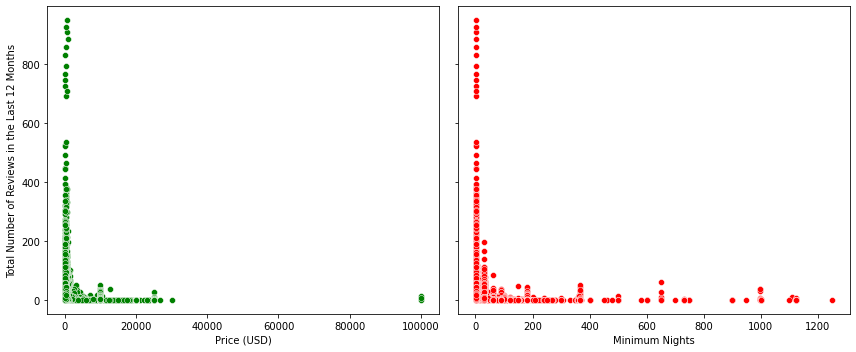

In [38]:
# Scatter Plots
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(12, 5))

sns.scatterplot(ax=axes.reshape(-1)[0], data=airbnb_usa, color='green',
                x='price', y='number_of_reviews_ltm')
axes.reshape(-1)[0].set(xlabel='Price (USD)',
                        ylabel='Total Number of Reviews in the Last 12 Months')

sns.scatterplot(ax=axes.reshape(-1)[1], data=airbnb_usa, color='red',
                x='minimum_nights', y='number_of_reviews_ltm')
axes.reshape(-1)[1].set(xlabel='Minimum Nights')

plt.tight_layout()

plt.show()

In [39]:
print('For price wth alternative=less:\n-', 
      stats.spearmanr(a=airbnb_usa['price'], 
                      b=airbnb_usa['number_of_reviews_ltm'], alternative='less'), 
      '\n\nFor minimum_nights wth alternative=less:\n-', 
      stats.spearmanr(a=airbnb_usa['minimum_nights'], 
                      b=airbnb_usa['number_of_reviews_ltm'], alternative='less'))

For price wth alternative=less:
- SpearmanrResult(correlation=-0.0040336140224811, pvalue=0.019105434404726063) 

For minimum_nights wth alternative=less:
- SpearmanrResult(correlation=-0.41275832098874043, pvalue=0.0)


Based on the Spearman Rank tests, on median, **listings with higher prices or minimum nights** have **lower number of reviews** in the last 12 months.

## Q4: Which listing room types on median have the highest/lowest number of reviews in the last 12 months?

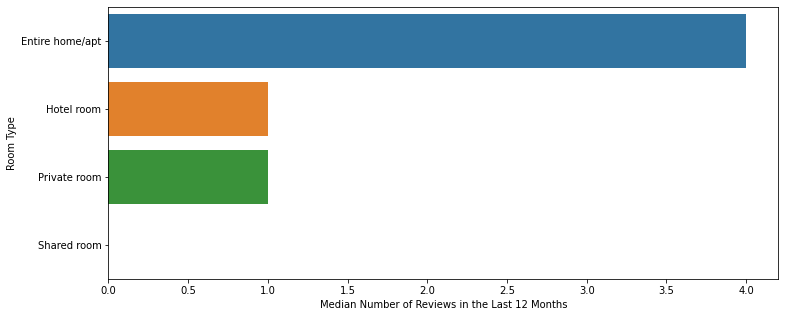

In [40]:
# Bar Plot
sns.barplot(data=airbnb_usa.groupby('room_type').median().reset_index(), x='number_of_reviews_ltm', y='room_type')
                       
plt.xlabel('Median Number of Reviews in the Last 12 Months')
plt.ylabel('Room Type') 
plt.gcf().set_size_inches(12, 5)
    
plt.show()

In [41]:
stats.kruskal(airbnb_usa.loc[airbnb_usa['room_type']=='Entire home/apt', 'number_of_reviews_ltm'], 
              airbnb_usa.loc[airbnb_usa['room_type']=='Hotel room', 'number_of_reviews_ltm'], 
              airbnb_usa.loc[airbnb_usa['room_type']=='Private room', 'number_of_reviews_ltm'], 
              airbnb_usa.loc[airbnb_usa['room_type']=='Shared room', 'number_of_reviews_ltm'])

KruskalResult(statistic=6851.843892860335, pvalue=0.0)

Based on the bar chart and Kruskal-Wallis test, on median, **'Entire home/apt' room types** have the **highest number of reviews** in the last 12 months while **'Shared room' room types** have the **lowest number of reviews** in the last 12 months.

## Q5: Do listings with indicated licenses on median differ from listings without indicated licenses in their numbers of reviews in the last 12 months?

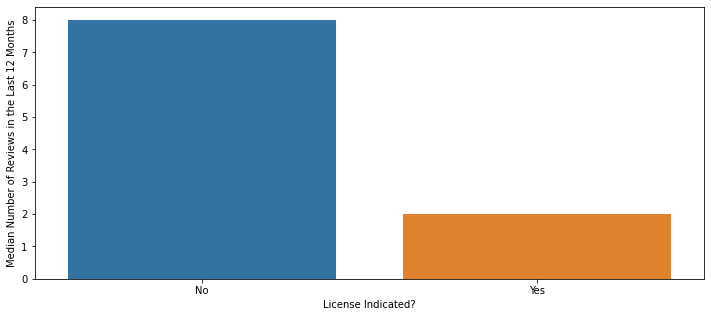

In [42]:
# Create a temporary DataFrame to store values
temp_df = airbnb_usa[['license', 'number_of_reviews_ltm']].copy()
temp_df['license_indicated'] = temp_df['license'].isnull().replace({True: 'Yes', False: 'No'})

# Bar Plot
sns.barplot(data=temp_df.groupby('license_indicated').median().reset_index(), 
            x='license_indicated', y='number_of_reviews_ltm')

plt.xlabel('License Indicated?')
plt.ylabel('Median Number of Reviews in the Last 12 Months')
plt.gcf().set_size_inches(12, 5)

plt.show()

In [43]:
stats.mannwhitneyu(x=temp_df.loc[temp_df['license_indicated']=='No', 'number_of_reviews_ltm'], 
                   y=temp_df.loc[temp_df['license_indicated']=='Yes', 'number_of_reviews_ltm'], 
                   alternative='greater')

MannwhitneyuResult(statistic=8366024761.5, pvalue=0.0)

Based on the Mann-Whitney U test, on median, **listings without indicated licenses** have **higher number of reviews** in the last 12 months than listings with indicated licenses.

# 6. Modeling
***

Let's predict a listing's number of reviews in the last 12 months: **number_of_reviews_ltm**.

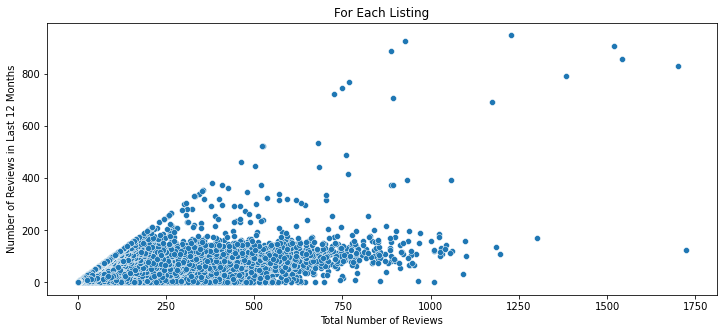

In [44]:
# Scatter Plot
sns.scatterplot(data=airbnb_usa.groupby('id').median(), x='number_of_reviews', y='number_of_reviews_ltm')

plt.xlabel('Total Number of Reviews')
plt.ylabel('Number of Reviews in Last 12 Months') 
plt.title('For Each Listing')
plt.gcf().set_size_inches(12, 5)

plt.show()

In [45]:
stats.spearmanr(a=airbnb_usa.groupby('id').median()['number_of_reviews'], 
                b=airbnb_usa.groupby('id').median()['number_of_reviews_ltm'], alternative='greater')

SpearmanrResult(correlation=0.7870762850446217, pvalue=0.0)

Based on the Spearman Rank test, on median, listings with higher number of reviews in total have higher number of reviews in the last 12 months; therefore, on median, listings with higher number of reviews in the last 12 months should also have higher number of reviews in the next 12 months (advance the time window).

## Missing Values

In [46]:
print('Missing values (%) per field:\n', 100*airbnb_usa.isnull().mean())

Missing values (%) per field:
 id                                 0.000000
name                               0.000379
host_id                            0.000000
host_name                          0.204151
neighbourhood_group               57.855465
neighbourhood                      0.264374
latitude                           0.000000
longitude                          0.000000
room_type                          0.000000
price                              0.000000
minimum_nights                     0.000000
number_of_reviews                  0.000000
last_review                       17.499053
reviews_per_month                 17.499053
calculated_host_listings_count     0.000000
availability_365                   0.000000
number_of_reviews_ltm              0.000000
license                           73.368684
state                              0.000000
city                               0.000000
dtype: float64


Let's:
* Drop **neighbourhood_group** since we have **city**
* Create **license_indicated** whether its 1 if a listing indicates a license or 0 if a listing doesn't indicate a license; although **license** is mostly **null**, it does correlate with **number_of_reviews_ltm** (please refer to the **Q5** section in the **Exploration** chapter above)
* Drop **last_review** and **reviews_per_month** which should allow our model to generalize to new listings

Finally, let's drop all **null** observations since they'll account for less than 0.3% of the total.

In [47]:
# Create a copy to avoid having to rerun the whole notebook
data = airbnb_usa.copy()

# Redefine features
data['license_indicated'] = data['license'].isnull().astype('int64')

# Drop 
data.drop(['neighbourhood_group', 'license', 'last_review', 'reviews_per_month'], 
          axis='columns', inplace=True)
data.dropna(inplace=True)

## Feature Extraction

In [48]:
data.head(5)

,id,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,number_of_reviews_ltm,state,city,license_indicated
0,183319,Panoramic Ocean View Venice Beach,867995,Barbara X,Venice,33.99211,-118.47600,Entire home/apt,152,30,3,2,0,0,CA,Los Angeles,1
1,109,Amazing bright elegant condo park front *UPGRA...,521,Paolo,Culver City,33.98301,-118.38607,Entire home/apt,115,30,2,1,139,0,CA,Los Angeles,1
2,51307,Spanish Bungalow Guest House LA CA. 30 plus ni...,235568,David,Atwater Village,34.12206,-118.26783,Entire home/apt,75,30,138,2,224,0,CA,Los Angeles,1
3,184314,Boho Chic Flat..Steps to Beach!,884031,Ashley,Venice,33.97487,-118.46312,Entire home/apt,125,30,30,1,0,0,CA,Los Angeles,1
4,51498,Guest House With Its Own Entrance/Exit and Hot...,236758,Bay,Mar Vista,34.00389,-118.44126,Entire home/apt,189,3,378,1,348,41,CA,Los Angeles,0


Let's drop:
* **id** and **host_id** since they're just generic identifiers
* **host_name** since we have **name** which contains more information on the listing
* **latitude** and **longitude** since they're just coordinates
* **number_of_reviews** which should allow us to generalize to new listings
* **neighbourhood**, **state** and **city** which should allow us to generalize to new USA neighbourhood, states and cities
* **calculated_host_listings_count** which should allow us to generalize to new hosts

Let's keep **name** in case we need to use text classification instead.

In [49]:
data.drop(['id', 'host_id', 'host_name', 'neighbourhood', 'latitude', 'longitude', 'number_of_reviews', 
           'state', 'city', 'calculated_host_listings_count'], axis='columns', inplace=True)

Let's create (and drop the input fields to avoid multicollinearity):
* Dummy variables for **room_type** with 'Entire home/apt' as the default case

In [50]:
data = pd.get_dummies(data, columns=['room_type'])
data.drop('room_type_Entire home/apt', axis='columns', inplace=True)

To get a clearer picture, let's drop all observations with **price = 0**.

In [51]:
data = data[data['price']>0]

## Multicollinearity

[]

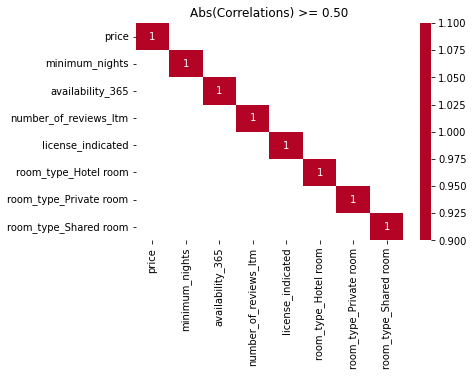

In [52]:
# Heatmap Plot of the Correlation Matrix with abs(coefficient) >= 0.50
_ = sns.heatmap(data.corr().round(2)[abs(data.corr().round(2)) >= 0.50] \
                    .dropna(how='all').dropna(axis='columns', how='all'), 
                center=0, cmap='coolwarm', annot=True, xticklabels=True, yticklabels=True)

plt.title('Abs(Correlations) >= 0.50')

plt.plot()

There are no strong correlations (i.e. abs(correlation)>=0.50).

## Scaling

Let's split the dataset into a train and test set then normalize **price** and **minimum_nights**.

In [53]:
# Split
X_train, X_test, y_train, y_test = train_test_split(data.drop('number_of_reviews_ltm', axis='columns'), 
                                                    data['number_of_reviews_ltm'], 
                                                    test_size = 0.30, random_state=111)

# Normalize
scaler_std = StandardScaler()
temp_list = ['price', 'minimum_nights'] # Subset to normalize only certain features
scaler_std.fit(X_train[temp_list].values)

X_train_scaled = X_train
X_test_scaled = X_test
X_train_scaled[temp_list] = scaler_std.transform(X_train[temp_list].values)
X_test_scaled[temp_list] = scaler_std.transform(X_test[temp_list].values)

# View X_train_scaled
X_train_scaled.head(5)

,name,price,minimum_nights,availability_365,license_indicated,room_type_Hotel room,room_type_Private room,room_type_Shared room
203597,Its a deal! Joyful Small room-3MinDrive Starbucks,-0.275703,-0.261976,350,1,0,1,0
294340,Chic downtown 6th St. Condo,-0.162753,-0.366808,101,1,0,0,0
321907,1 Bedroom Seattle Condo near Capital,-0.218026,0.611620,274,1,0,0,0
118223,NEW Modern Home With Amazing Views of the Ocean!,0.332305,-0.261976,177,1,0,0,0
267998,Sleek Modern Metropolitan Retreat,-0.160349,0.611620,287,1,0,0,0


## Model Search

Let's try to find a suitable base model using regression algorithms.

In [54]:
# Setup
reg_base_models = {'Linear Regression': LinearRegression(), 
                   'Ridge Regression': Ridge(), 'Lasso Regression': Lasso(), 
                   'K Neighbors Regressor': KNeighborsRegressor(),
                   'Random Forest Regressor': RandomForestRegressor()}
kf = KFold(n_splits=5, random_state=111, shuffle=True)
R2 = {'Linear Regression': [], 'Ridge Regression': [], 'Lasso Regression': [], 
      'K Neighbors Regressor': [], 'Random Forest Regressor': []}

# Test Regression Base Models
print('Testing Regression Base Models:\n')
for i, val in enumerate(reg_base_models.items()):
    name, model = val
    
    print('Model', i+1, 'of', len(reg_base_models), ':', name)
    for j, index in enumerate(kf.split(X_train_scaled.drop('name', axis='columns'))):
        # Status
        print('- Folds:', j+1, '/', kf.get_n_splits(), end='\r')
        
        # Split data
        X_train_sub, X_hold = (X_train_scaled.drop('name', axis='columns').iloc[index[0]], 
                                    X_train_scaled.drop('name', axis='columns').iloc[index[1]])
        y_train_sub, y_hold = y_train.iloc[index[0]], y_train.iloc[index[1]]
        
        # Fit and evaluate
        model.fit(X_train_sub, y_train_sub)
        R2[name] = [*R2[name], model.score(X_hold, y_hold)]
    print()
    
print('\nCompleted.')

Testing Regression Base Models:

Model 1 of 5 : Linear Regression
- Folds: 5 / 5
Model 2 of 5 : Ridge Regression
- Folds: 5 / 5
Model 3 of 5 : Lasso Regression
- Folds: 5 / 5
Model 4 of 5 : K Neighbors Regressor
- Folds: 5 / 5
Model 5 of 5 : Random Forest Regressor
- Folds: 5 / 5

Completed.


In [55]:
# Results
temp_df = pd.DataFrame(data=R2.values(), index=R2.keys()) \
            .apply(['mean', 'std'], axis='columns') \
            .apply([lambda row: row['mean'] - 2*row['std'],
                    lambda row: row['mean'] + 2*row['std']], axis='columns')
temp_df.columns = ['R2_95CI_Lower','R2_95CI_Upper']
temp_df.sort_values(['R2_95CI_Lower', 'R2_95CI_Upper'], ascending=False)

,R2_95CI_Lower,R2_95CI_Upper
K Neighbors Regressor,0.095471,0.126693
Random Forest Regressor,0.095415,0.125039
Ridge Regression,0.048350,0.069944
Linear Regression,0.048349,0.069945
Lasso Regression,0.030769,0.042865


Since the highest R2 values are below 0.50 (equivalent to 50% accuracy), let's try classification algorithms instead. 

Let's redefine **number_of_reviews_ltm** as a binary variable, **number_of_reviews_ltm_greater48**, where its 1 when **number_of_reviews_ltm_greater48** >= 48 (i.e. >= 1 review per week) and its 0 when **number_of_reviews_ltm_greater48** < 48, resplit using stratified sampling then renormalize **price** and **minimum_nights**.

In [56]:
# Create number_of_reviews_ltm_greater48
data['number_of_reviews_ltm_greater48'] = [1 if n >= 48 else 0 for n in data['number_of_reviews_ltm']]

# Resplit
X_train, X_test, y_train, y_test = train_test_split(data.drop(['number_of_reviews_ltm_greater48', 'number_of_reviews_ltm'], 
                                                              axis='columns'), 
                                                    data['number_of_reviews_ltm_greater48'], 
                                                    test_size = 0.30, random_state=111, 
                                                    stratify=data['number_of_reviews_ltm_greater48'])

# Renormalize
scaler_std = StandardScaler()
temp_list = ['price', 'minimum_nights'] # Subset to normalize only certain features
scaler_std.fit(X_train[temp_list].values)

X_train_scaled = X_train
X_test_scaled = X_test
X_train_scaled[temp_list] = scaler_std.transform(X_train[temp_list].values)
X_test_scaled[temp_list] = scaler_std.transform(X_test[temp_list].values)

# View y_train
y_train.value_counts()

0    172261
1     11621
Name: number_of_reviews_ltm_greater48, dtype: int64

Let's now try to find a suitable base model using classification algorithms.

In [57]:
# Suppress all warnings
import warnings
warnings.filterwarnings('ignore')

# Test Classification Base Models
class_base_models = {'Logistic Regression': LogisticRegression(), 
                     'KNN': KNeighborsClassifier(), 'SVM': SVC(), 
                     'Random Forest': RandomForestClassifier()}

for name, base in class_base_models.items():
    base.fit(X_train_scaled.drop('name', axis='columns'), y_train)
    print('For', name, ': \n', 
          classification_report(base.predict(X_test_scaled.drop('name', axis='columns')), y_test))

For Logistic Regression : 
               precision    recall  f1-score   support

           0       1.00      0.94      0.97     78807
           1       0.00      0.00      0.00         0

    accuracy                           0.94     78807
   macro avg       0.50      0.47      0.48     78807
weighted avg       1.00      0.94      0.97     78807

For KNN : 
               precision    recall  f1-score   support

           0       0.99      0.94      0.96     77393
           1       0.07      0.24      0.11      1414

    accuracy                           0.93     78807
   macro avg       0.53      0.59      0.54     78807
weighted avg       0.97      0.93      0.95     78807

For SVM : 
               precision    recall  f1-score   support

           0       1.00      0.94      0.97     78807
           1       0.00      0.00      0.00         0

    accuracy                           0.94     78807
   macro avg       0.50      0.47      0.48     78807
weighted avg       1.0

Based on the precision score (not referring to the accuracy score since the labels differ in amount) and interpretability of the model, let's use Logistic Regression as the base model.

## Model Tuning

Let's try to tune its hyperparameters.

In [58]:
# Search
model_tuned = GridSearchCV(estimator=LogisticRegression(), cv=5, verbose=2.5,
                           param_grid={'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                                       'C': [100, 10, 1.0, 0.1, 0.01]})
model_tuned.fit(X_train_scaled.drop('name', axis='columns'), y_train)

# Best Model
model_best = model_tuned.best_estimator_
model_best.fit(X_train_scaled.drop('name', axis='columns'), y_train)
print('\nBest Model:', model_best,'\n',
      classification_report(model_best.predict(X_test_scaled.drop('name', axis='columns')), y_test))

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ...........C=100, solver=newton-cg;, score=0.937 total time=   6.1s
[CV 2/5] END ...........C=100, solver=newton-cg;, score=0.937 total time=   7.3s
[CV 3/5] END ...........C=100, solver=newton-cg;, score=0.937 total time=   7.2s
[CV 4/5] END ...........C=100, solver=newton-cg;, score=0.937 total time=   7.3s
[CV 5/5] END ...........C=100, solver=newton-cg;, score=0.937 total time=   7.9s
[CV 1/5] END ...............C=100, solver=lbfgs;, score=0.937 total time=   1.8s
[CV 2/5] END ...............C=100, solver=lbfgs;, score=0.937 total time=   2.3s
[CV 3/5] END ...............C=100, solver=lbfgs;, score=0.937 total time=   2.2s
[CV 4/5] END ...............C=100, solver=lbfgs;, score=0.937 total time=   2.1s
[CV 5/5] END ...............C=100, solver=lbfgs;, score=0.937 total time=   2.0s
[CV 1/5] END ...........C=100, solver=liblinear;, score=0.937 total time=   0.6s
[CV 2/5] END ...........C=100, solver=liblinear

In [59]:
# Create a temporary DataFrame to store values
temp_df = pd.DataFrame({'logreg_features': model_best.feature_names_in_, 
                        'logreg_coeff': model_best.coef_[0]}) \
            .sort_values('logreg_coeff', ascending=False)

# Views its features and coefficients
temp_df

,logreg_features,logreg_coeff
2,availability_365,-0.000120
4,room_type_Hotel room,-0.425174
3,license_indicated,-0.455395
5,room_type_Private room,-0.847207
6,room_type_Shared room,-1.857265
0,price,-3.339520
1,minimum_nights,-4.834101


Although the tuned model has the same precison score as the base model, let's keep it.

## Model Reduction

Let's try to reduce it by keeping only its features with abs(coefficients) >= 1.

In [60]:
# Create a temporary List to store values
temp_list = list(model_best.feature_names_in_ [abs(model_best.coef_[0]) >= 1])

# Best Model Reduced
model_best_reduced = LogisticRegression(C=100, solver='newton-cg')
model_best_reduced.fit(X_train_scaled[temp_list], y_train)
print('\nBest Model Reduced:', model_best_reduced,'\n',
      classification_report(model_best_reduced.predict(X_test_scaled[temp_list]), y_test))


Best Model Reduced: LogisticRegression(C=100, solver='newton-cg') 
               precision    recall  f1-score   support

           0       1.00      0.94      0.97     78807
           1       0.00      0.00      0.00         0

    accuracy                           0.94     78807
   macro avg       0.50      0.47      0.48     78807
weighted avg       1.00      0.94      0.97     78807



In [61]:
# Create a temporary DataFrame to store values
temp_df = pd.DataFrame({'logreg_features': model_best_reduced.feature_names_in_, 
                        'logreg_coeff': model_best_reduced.coef_[0]}) \
            .sort_values('logreg_coeff', ascending=False)

# Views its features and coefficients
temp_df

,logreg_features,logreg_coeff
2,room_type_Shared room,-1.587977
0,price,-2.403703
1,minimum_nights,-4.740241


Logistic Regression Final Model:

    number_of_reviews_ltm_greater48 = - 1.587977*(room_type_Shared room) - 2.403703*(price) - 4.740241*(minimum_nights)
                
With 100% precision and 94% recall, this model can classify if a listing has its number of reviews in the last 12 months < 48 (i.e. < 1 review per week); since a listing's number of reviews in total highly correlates with its number of reviews in the last 12 months, this model should also hold for its number of reviews in the next 12 months.
* **Positive** features (increases the likelihood of a listing having its number of reviews in the last 12 months >= 48): None
* **Negative** features (decreases the likelihood of a listing having its number of reviews in the last 12 months < 48): Room type = 'Shared room', Price (USD) > 0 and Minimum nights > 0.
* **Baseline** features (neutral): Room type = 'Entire home/apt'.

# 7. Appendix
***

## Metadata

Data source: Collected by me from **Inside Airbnb**: http://insideairbnb.com/get-the-data/

| Field                           | Description                                                               |
|---------------------------------|---------------------------------------------------------------------------|
| id                              | Airbnb's unique identifier for the listing                                |
| name                            | Name of the listing                                                       |
| host_id                         | Airbnb's unique identifier for the host/user                              |
| host_name                       | Name of the host. Usually just the first name(s)                          |
| neighbourhood_group             | The neighbourhood group as geocoded using the latitude and longitude against neighborhoods as defined by open or public digital shapefiles                                                                                  |
| neighbourhood                   | Location of the listing                                                   |
| latitude                        | Latitude of the listing (uses World Geodetic System (WGS84) projection)   |                                   
| longitude                       | Longitude of the listing (uses World Geodetic System (WGS84) projection)  |
| room_type                       | Room type of the listing: 'Entire home/apt', 'Private room',  'Shared room', 'Hotel'                                                                                        |
| price                           | Daily price of the listing in the local currency                          |
| minimum_nights                  | Minimum number of night stay of the listing (calendar rules may differ)   |
| number_of_reviews               | The total number of reviews of the listing                                |
| last_review                     | The date of the last (newest) review of the listing                       |
| reviews_per_month               | The total number of reviews per month of the listing                              |
| calculated_host_listings_count  | The total number of listings the host has in the city/region area         |
| availability_365                | The availability of the listing 365 days in advance (determined by the calendar); please note that a listing may not be available because it has either been booked by a guest or blocked by the host.                     |
| number_of_reviews_ltm           | The total number of reviews the listing has in the last 12 months         |
| license                         | The license/permit/registration number                                    |
| state                           | State of the listing abbreviated (added in)                                           |
| city                            | City/County of the listing (added in)                                            |

## Miscellaneous
1. Header image: Google searched 'Airbnb Logo Large'
2. 'Gold-Diggers Hotel' listing: https://www.airbnb.com/hotels/40561078?c=.pi0.pk9495470343_94675444457&gclid=Cj0KCQiAyMKbBhD1ARIsANs7rEGUI4la1aA7lZUzzNR_oSP4bpnos3MiwzRltELwkrvVJrhnup34paIaAjKREALw_wcB&source_impression_id=p3_1668373975_KbOWBLfGJZBDMGpd
3. 'WELCOME to "WORLD MAP SUITE" in the heart of P.B.!' listing: https://www.airbnb.com/rooms/47475849?source_impression_id=p3_1668375667_NGZ5ERIQH1ETMFcw